## Data description

The dataset contains transactions made by credit cards that occurred in two days, where we have 492 frauds out of 284,807 transactions.

The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation.

Unfortunately, due to confidentiality issues, the original features are not provided, and the only features that were not trasformed with PCA are 'Time' and 'Amount'.

- `Time` : Contains the seconds elapsed between each transaction
- `Amount` : Transaction amount
- `Class` : The target variable and it takesvalue 1 in case of fraud and 0 otherwise

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix, plot_confusion_matrix, precision_score, recall_score, roc_auc_score
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler


In [24]:
rs = 463

In [25]:
df = pd.read_csv("creditcard.csv", index_col=False)

In [26]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [27]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

<AxesSubplot:>

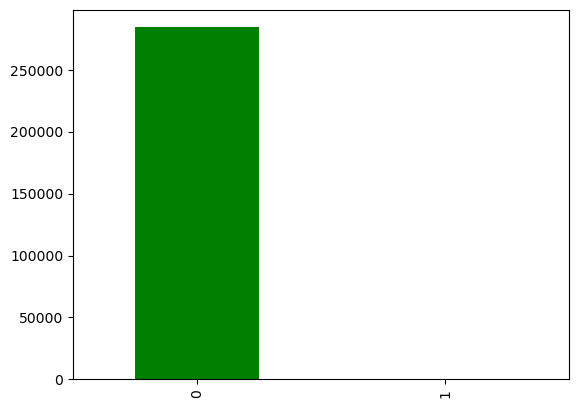

In [28]:
# Visualize the count for each class
df['Class'].value_counts().plot.bar(color=['green', 'red'])

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [30]:
df.loc[:, ['Time', 'Amount']].describe()

,Time,Amount
count,284807.000000,284807.000000
mean,94813.859575,88.349619
std,47488.145955,250.120109
min,0.000000,0.000000
25%,54201.500000,5.600000
50%,84692.000000,22.000000
75%,139320.500000,77.165000
max,172792.000000,25691.160000


C:\Users\Utilisateur\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Amount Distribution'}, xlabel='Amount', ylabel='Density'>

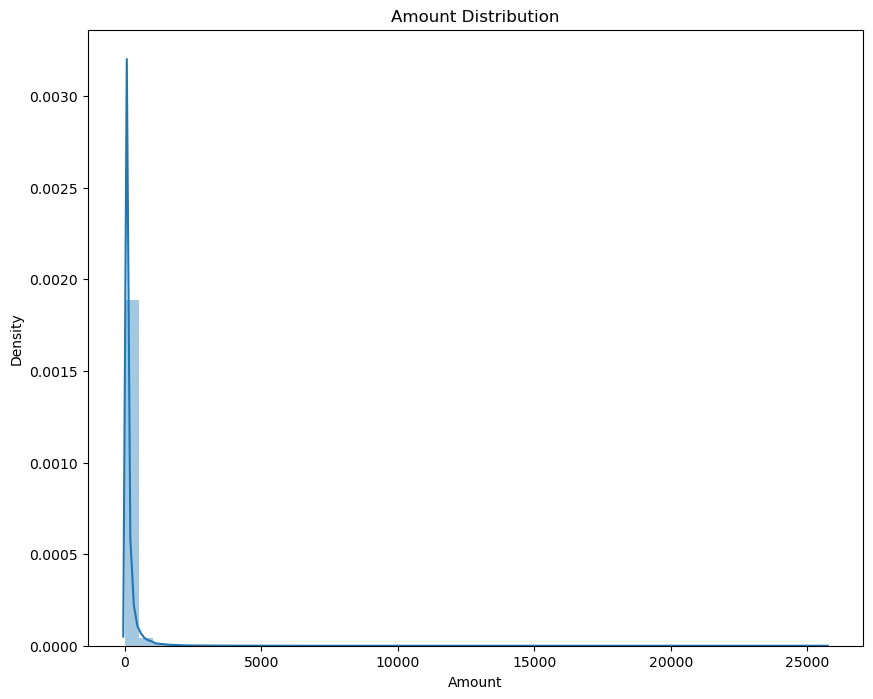

In [31]:
plt.figure(figsize=(10,8))
plt.title('Amount Distribution')
sns.distplot(df['Amount'])

The feature 'Amount' is highly skewed to the right, this can impact the performance of machine learning models, especially when dealing with sensitive tasks like fraud detection. So to tackle the problem, we are going to apply logarithmic transformation to the feature.

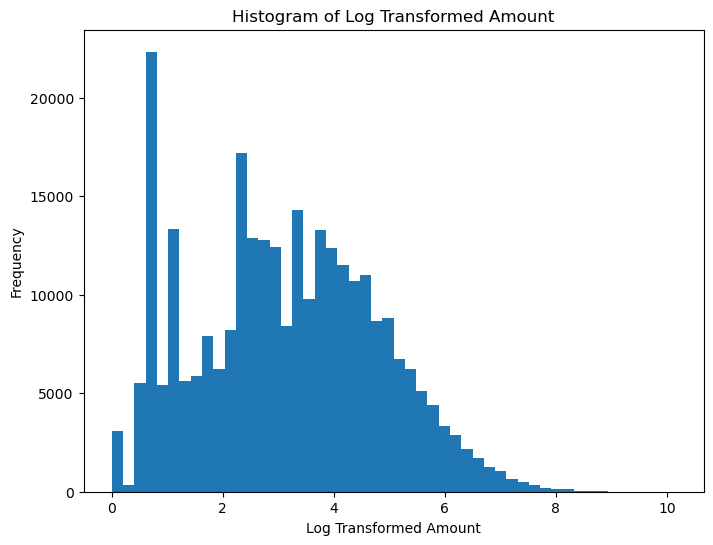

In [32]:
df['Amount'] = np.log1p(df['Amount'])

plt.figure(figsize=(8, 6))
plt.hist(df['Amount'], bins=50)
plt.xlabel('Log Transformed Amount')
plt.ylabel('Frequency')
plt.title('Histogram of Log Transformed Amount')
plt.show()

## Main objectives of this analysis

The primary objective of my this project is to analyze the card fraud dataset and determine the most effective method to balance the data, leading to the development of a good classifier for predicting fraudulent cards.

Precision and recall are two important evaluation metrics in binary classification tasks like fraud detection, but we are going to prioritize recall over precision in this case.

In the context of fraud detection, missing actual fraudulent transactions (false negatives) can be much more costly and harmful than falsely flagging legitimate transactions as fraud (false positives). A high recall ensures that the model can identify as many actual fraudulent cases as possible, reducing the chances of overlooking fraudulent activities.

- Precision is the ratio of true positive predictions to the total predicted positive instances. It represents the accuracy of positive predictions made by the model. A high precision means that when the model predicts an instance as positive (fraudulent), it is very likely to be correct.

- Recall is the ratio of true positive predictions to the total actual positive instances in the dataset. It measures the model's ability to identify all positive instances correctly. High recall means the model can capture a significant portion of actual fraudulent cases.

## Train and fit different models

In [33]:
# Split the training and testing dataset
X = df.loc[ : , df.columns != 'Class']
y = df['Class'].astype('int')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state = rs)

In [34]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

## Logistic regression

In [35]:
# Build a simple logistic regression model
model = LogisticRegression(random_state=rs, 
                              max_iter = 1000)

# Train the model
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [36]:
accuracy = accuracy_score(y_test, preds)
accuracy

0.9992451107756047

The accuracy is good, but it is not good enough to draw conclusions about this imbalanced dataset.
In order to gain more insights about the results of logistic regression, we are gonna measure other metrics.

In [37]:
def displayMetrics(y_test, preds): 
    precision, recall, f_beta, support = precision_recall_fscore_support(y_test, preds, beta=5, pos_label=1, average='binary')
    auc = roc_auc_score(y_test, preds)
    accuracy = accuracy_score(y_test, preds)
    print(f"Accuracy is: {accuracy:.2f}")
    print(f"Precision is: {precision:.2f}")
    print(f"Recall is: {recall:.2f}")
    print(f"Fscore is: {f_beta:.2f}")
    print(f"AUC is: {auc:.2f}")

In [38]:
displayMetrics(y_test, preds)

Accuracy is: 1.00
Precision is: 0.89
Recall is: 0.64
Fscore is: 0.65
AUC is: 0.82


## Logistic regression with SMOTE sampler

We can see here that recall is lower than precision, and for this specific problem recall is more important because we want to detect fraud if there is one.
We want to improve recall but keep precision as high as possible, in order to do that, we are going to use technics to balance the dataset.

In [39]:
# Create a SMOTE sampler
smote_sampler = SMOTE(random_state = rs)

# Resample training data using SMOTE
X_smo, y_smo = smote_sampler.fit_resample(X_train, y_train)

<AxesSubplot:>

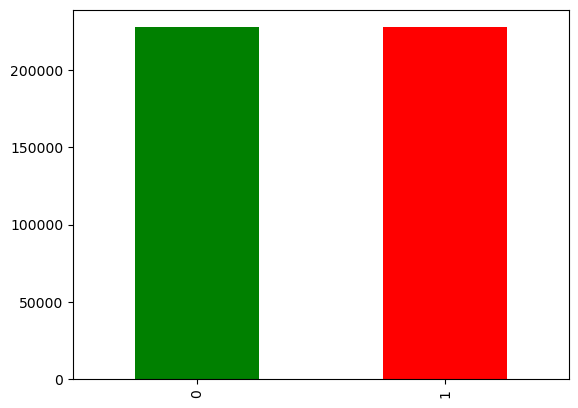

In [40]:
# Visualize classes
y_smo.value_counts().plot.bar(color=['green', 'red'])

In [41]:
# Re-train the model with resampled data
model.fit(X_smo, y_smo)
preds = model.predict(X_test)

In [42]:
displayMetrics(y_test, preds)

Accuracy is: 0.98
Precision is: 0.09
Recall is: 0.90
Fscore is: 0.66
AUC is: 0.94


Recall is good but the precision is very poor, it means that normal transactions will be flagged as a fraud, which is not good etheir, card horlders will see their card blocked for this reason and we don't want that to happen frequently.

In this case, we have an extremely skewed dataset, we generally do not use oversampling as it significantly shifts the original data distribution, that's why the precision is so poor.

We are going to try reweighting

## Logistic regression with reweighting

In [43]:
model = LogisticRegression(random_state=rs, 
                              max_iter = 2000)

param_grid = {
    'class_weight': ['balanced', {0: 0.172, 1: 0.828}, {0: 0.3, 1: 0.7}, {0: 0.2, 1: 0.8}],
    'C': [0.01, 0.1, 1, 10, 100]
}

# Use GridSearchCV to find the best hyperparameters and class weights
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

# Access the best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

In [44]:
best_model

LogisticRegression(C=100, class_weight={0: 0.2, 1: 0.8}, max_iter=2000,
                   random_state=463)

In [45]:
# Train the model
best_model.fit(X_train, y_train)
preds = best_model.predict(X_test)

In [46]:
displayMetrics(y_test, preds)

Accuracy is: 1.00
Precision is: 0.86
Recall is: 0.74
Fscore is: 0.75
AUC is: 0.87


In [ ]:
# Create a Random Forest classifier
rf_model = RandomForestClassifier(random_state=42, n_estimators=50)

# Define the grid of hyperparameters to search
param_grid = {
    'max_depth': [5, 10, 20],           # Maximum depth of the trees
    'class_weight': [{0: 0.172, 1: 0.828}, {0: 0.3, 1: 0.7}, {0: 0.2, 1: 0.8}]        # Class weights to handle imbalanced classes
}

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='f1', verbose=1)
grid_search.fit(X_train, y_train)

# Access the best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

## Random forest with reweighting

In [52]:
best_model = RandomForestClassifier(class_weight={0: 0.172, 1: 0.828}, n_estimators=50,
                       random_state=42)

In [53]:
best_model.fit(X_train, y_train)
preds = best_model.predict(X_test)

In [54]:
displayMetrics(y_test, preds)

Accuracy is: 1.00
Precision is: 1.00
Recall is: 0.78
Fscore is: 0.78
AUC is: 0.89


In [57]:
def get_accuracy(X_train, X_test, y_train, y_test, model):
    return  {"test Accuracy": accuracy_score(y_test, model.predict(X_test)),"train Accuracy":  accuracy_score(y_train, model.predict(X_train))}

In [58]:
get_accuracy(X_train, X_test, y_train, y_test, best_model)

{'test Accuracy': 0.9996137776061234, 'train Accuracy': 0.9999780552568632}

In [59]:
feature_importances = best_model.feature_importances_

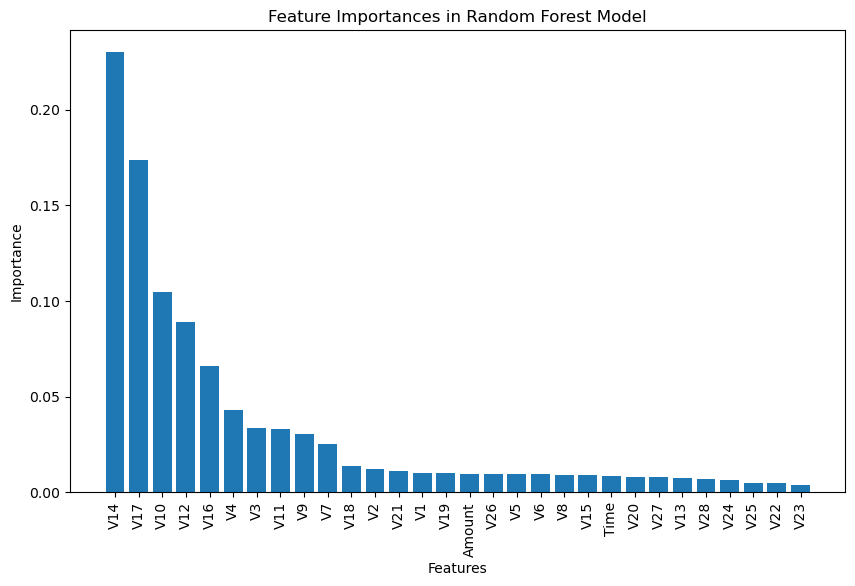

In [60]:
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance values in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances in Random Forest Model')
plt.show()

In [62]:
threshold = 0.03

low_importance_features_indices = np.where(feature_importances < threshold)[0]
X_reduced = np.delete(X, low_importance_features_indices, axis=1)

In [63]:
X_reduced

array([[ 1.6727735 ,  0.97336551,  0.33112778, ..., -0.32461019,
        -0.53683287,  0.24486345],
       [ 0.1097971 ,  0.31652293, -0.23249419, ..., -0.14998248,
         0.52943375, -0.13516997],
       [ 1.16946849,  0.26823129, -1.37867535, ..., -0.17311389,
        -3.29823537,  1.30686788],
       ...,
       [-2.14320514, -0.39398367,  0.39363023, ..., -0.53265708,
         0.1605886 ,  0.36911416],
       [ 0.46332013,  0.48719238,  0.3568869 , ...,  0.46904579,
        -0.69452347,  0.60038514],
       [ 0.46386564, -0.35757   ,  0.44253246, ..., -0.08795849,
        -0.34535763, -0.77752147]])

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, stratify=y, random_state = rs)

In [65]:
best_model.fit(X_train, y_train)
preds = best_model.predict(X_test)

displayMetrics(y_test, preds)

Accuracy is: 1.00
Precision is: 1.00
Recall is: 0.81
Fscore is: 0.81
AUC is: 0.90


In [66]:
get_accuracy(X_train, X_test, y_train, y_test, best_model)

{'test Accuracy': 0.9996664442961974, 'train Accuracy': 0.9999780552568632}

## Key findings

The key findings are as follows:

- Without balancing the dataset, the recall is low.
- After applying oversampling techniques, the recall increases, but the precision becomes very low.
- By adjusting the weights of each class, the model's performance improves.
- Further improvement is achieved by removing less important features, although the precision remains higher than the recall. In this specific case of card fraud detection, high recall is more important to minimize false negatives and capture more fraudulent transactions.

## Possible flaws in the model and a plan of action to revisit this analysis with additional data or different predictive modeling techniques 

The findings highlight the importance of balancing class distribution, adjusting class weights, and performing feature selection to optimize the model's performance for fraud detection.

However, it's essential to continue fine-tuning the model and considering other strategies to achieve the desired balance between precision and recall. Always evaluate the model's performance on validation or test data and collaborate with domain experts to ensure the model aligns with the business requirements and objectives.

Additionally, for complex and highly non-linear problems like fraud detection, it might be worth exploring deep learning approaches. Deep learning models, such as neural networks and deep autoencoders, can capture intricate patterns and relationships in the data, potentially leading to improved performance in fraud detection tasks. Deep learning models can be especially effective when dealing with high-dimensional and unstructured data, such as transactional data.